1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df = df.drop(['Unnamed: 0'],1)

df.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
#convert to categorical variables
df["default"] = df["default"].astype('category')
df["student"] = df["student"].astype('category')
#reassign categorical values
df["default"]= df["default"].cat.rename_categories([0,1])
df["student"] = df["student"].cat.rename_categories([0,1])

df.head(5)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

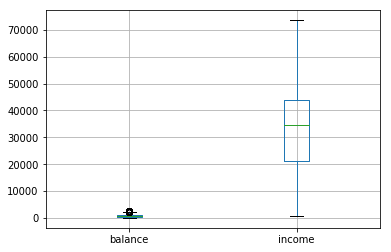

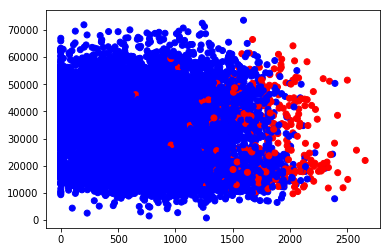

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df.boxplot(return_type='axes')
plt.show()

color= ['red' if default == 1 else 'blue' for default in df.default]
plt.scatter(df.balance, df.income, color=color)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

Area under the ROC curve : 0.932928


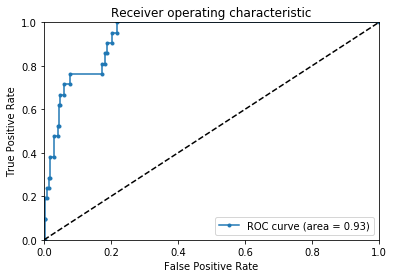

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

#our dataset
df_1 = df[df.student != 0]
y = df_1['default']
#X = df_1.drop(['default'],1)
X = df_1.drop(['default','student'],1)

#split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create logistic regression object
regr = LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

#get predicted y values for the testing dataset
y_predict = regr.predict(X_test)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)




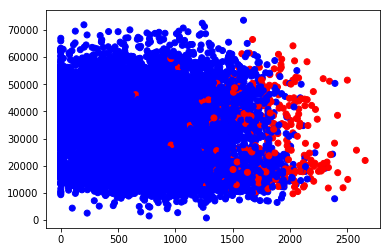

(2944, 2)
[[  3.56065058e-178   0.00000000e+000]
 [  2.06009760e-200   0.00000000e+000]
 [  2.51236419e-176   0.00000000e+000]
 ..., 
 [  1.02061888e-217   0.00000000e+000]
 [  3.63911236e-038   0.00000000e+000]
 [  2.34586165e-044   0.00000000e+000]]


ValueError: shapes (2944,2) and (1,2944) not aligned: 2 (dim 1) != 1 (dim 0)

In [14]:
#recreate the scatter plot
color= ['red' if default == 1 else 'blue' for default in df.default]
plt.scatter(df.balance, df.income, color=color)
plt.show()

#add decision boundary to the previous scatter plot

theta = 0.5

def sigmoid(z):
    print(z.shape)
    print(np.exp(-z))
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y):
    #theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    #first = np.dot( -y, )
    first = np.log(sigmoid(X*theta[0])).dot(-y)
    second = np.multiply((1-y), np.log(1-sigmoid(X * theta[0])))
    return np.sum(first -  second)/(len(X))
#np.dot(np.ones((97,2)), np.ones((2,1)))

def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    error = sigmoid(X*theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
        
    return grad

import scipy.optimize as opt

result = opt.fmin_tnc(func=cost, x0=theta, args=(X, np.array(y)), 
                      #fprime=gradient
                     )
#cost(X, y, result[0])
bound = decision_boundary(y)

color= ['red' if default == 1 else 'blue' for default in df.default]
plt.scatter(df.balance, df.income, bound, color=color)
plt.show()


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

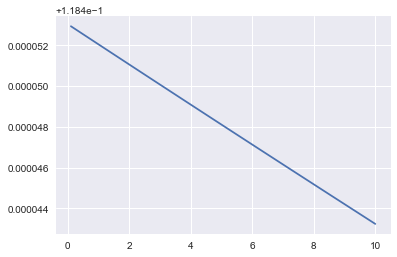

Area under the ROC curve : 0.962252262573


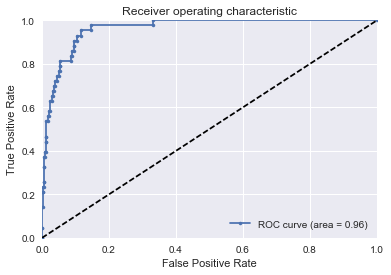

In [28]:
#our dataset
y = df['default']
X = df.drop(['default'],1)
size = len(y)

# Split the data into training/testing sets
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

# Split the targets into training/testing sets
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

# Create linear regression object
alphas = np.logspace(-1,1,30)

scores = []

for alpha in alphas:
    regr = Ridge(alpha=alpha)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test,y_test))
plt.plot(alphas,scores)
plt.show()

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve :", roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)




The performance improves with the added variable.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [31]:
scores=[]

# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = cross_validation.KFold(len(y),n_folds=5,shuffle=True)
    #y_pred = y.copy()
   
    # Iterate through folds
    for train, test in kf:
        X_train, X_test = X[train], X[test]
        y_train = y[train]
        regr.fit(X_train, y_train)
        scores.append(regr.score(X_test,y_test))
        
        # Initialize a classifier with key word arguments
        #clf = clf_class(**kwargs)
        #clf.fit(X_train,y_train)
        #y_pred[test] = clf.predict(X_test)
        
    return plt.plot(kf,scores)

    

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

Visualize the decision tree & Use R^2 to compare performance

In [12]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy.random as nprnd
import random
import seaborn
%matplotlib inline

#our dataset
df_1 = df[df.student != 0]
y = df_1['default']
X = df_1.drop(['default'],1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=1)
regr_2 = DecisionTreeRegressor(max_depth=2)
regr_3 = DecisionTreeRegressor(max_depth=3)
regr_4 = DecisionTreeRegressor(max_depth=4)
regr_5 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)
regr_5.fit(X, y)

# Predict
df_ran = df_1.sample(frac=0.7)
y_test = df_ran['default']
X_test = df_ran.drop(['default'],1)
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
y_4 = regr_4.predict(X_test)
y_5 = regr_5.predict(X_test)

#define a function to visualize the tree
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

#import libraries for visualizing the decision tree
from __future__ import print_function
import os
import subprocess
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image  
import pydotplus 
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.externals.six import StringIO

#plot the decision tree for depth=1

#dot_data = StringIO() 
#dt=DecisionTreeRegressor(max_depth=1)
#tree.export_graphviz(dt, out_file=dot_data, feature_names=X.columns)  
#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png()) 

dot_data = StringIO()
dt=DecisionTreeRegressor(max_depth=1)
print(type(tree))
tree.export_graphviz(dt, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("iris.pdf")
Image(graph.create_png()) 

#dt=DecisionTreeRegressor(max_depth=1)
#visualize_tree(regr_1, feature_names=['x'])
#dot_data= tree.export_graphviz(regr_1, outfile=None)
#tree.export_graphviz(dt, out_file=dot_data, feature_names=X.columns) 
#graph = pydot.graph_from_dot_data(dot_data)  
#graph = pydot.graphviz.graph_from_dot_data(dot_data)  
#Image(graph.create_png()) 

#plot the decision tree for depth=2
dt=DecisionTreeRegressor(max_depth=2)
visualize_tree(regr_2, feature_names=['x'])
dot_data=export_graphviz(regr_2, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#plot the decision tree for depth=3
dt=DecisionTreeRegressor(max_depth=3)
visualize_tree(regr_3, feature_names=['x'])
dot_data=export_graphviz(regr_3, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#plot the decision tree for depth=4
dt=DecisionTreeRegressor(max_depth=4)
visualize_tree(regr_4, feature_names=['x'])
dot_data=export_graphviz(regr_4, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#plot the decision tree for depth=5
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr_5, feature_names=['x'])
dot_data=export_graphviz(regr_5, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 





<class 'module'>


AttributeError: 'NoneType' object has no attribute 'children_left'

The optimal depth is 2


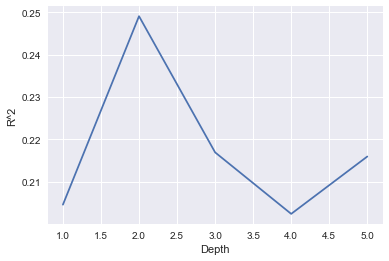

In [13]:
#our dataset
df_1 = df[df.student != 0]
y = df_1['default']
X = df_1.drop(['default'],1)

#compute R^2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
print('The optimal depth is ' + str(n_opt))


8) Find the optimal decision tree depth and compute the AUC ROC. 

From (7), we know the optimal decision tree depth is 2.

Area under the ROC curve : 0.932827


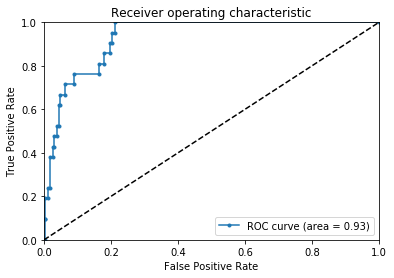

In [16]:
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)


Backup codes

In [ ]:
# Necssary libraries
import pandas as pd
#import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
#from mpl_toolkits.basemap import Basemap
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random